# DSCI 100 Group Project Proposal: Heart Disease Diagnosis Classification

## 1. Introduction

Heart disease is a term that refers to any condition that affects the function of the heart (Chambers, 2021). As heart disease is the leading cause of death globally, our project aims to consider several risk factors and answer the question, **“Can we predict the diagnosis of heart disease for an individual based on their maximum heart rate, blood pressure, and age?”** (Virani, 2021).

We will answer this question using the Heart Disease Data Set from the UCI Machine Learning Repository. The dataset provides data on an individual’s values for different risk factors including their age, maximum heart rate, blood pressure, and serum cholesterol.

## 2. Preliminary Exploratory Data Analysis
#### Reading the Data

First, we begin by loading the relevant library packages and reading the dataset from the web into R.

In [16]:
# loading relevant library packages
library(repr)
library(tidyverse)
library(tidymodels)
library(cowplot)

options(repr.matrix.max.rows = 6)

In [17]:
# reading the dataset from the web
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"

heart_data <- read_delim(url,
                         col_names = c("age", "sex", "cp", "trestbps", 
                                         "chol", "fbs", "restecg", "thalach", 
                                         "exang", "oldpeak", "slope", "ca", "thal", "num"))
heart_data

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


*Table 1: Heart Disease Dataset from the Web*

The original dataset was read into R and the columns were renamed to the original attributes listed from the web. The description of each attribute is as follows:

- `age` - Age of the individual (years)
- `sex` - Sex of the individual (1 = male; 0 = female)
- `cp` - Chest pain type (1 = typical angina; 2 = atypical angina; 3 = non-anginal pain; 4= asymptomatic)
- `trestbps` - Resting blood pressure (mm Hg)
- `chol` - Total cholesterol in blood (mg/dl)
- `fbs` - If fasting blood sugar is greater than 120 mg/dl (1 = true; 2 = false)
- `restecg` - Resting electrocardiographic results (0 = normal; 1 = abnormal, 2 = hypertrophy)
- `thalach` - Maximum heart rate achieved
- `exang` - Exercise induced angina (1 = yes; 0 = no)
- `oldpeak` - ST depression induced by exercise relative to rest
- `slope` - Slope of the peak exercise ST segment
- `ca` - Number of major vessels (0-3)
- `thal` - Thalassemia (3 = normal; 6 = fixed defect, 7 = reversable)
- `num` - Diagnosis of heart disease (1 = true, 0 = false)

Next, although the dataset is already tidy, we can make a few improvements relevant to our project:
- First, we rename a few important columns with more descriptive titles to provide a clearer understanding of the dataset.
- As the diagnosis column is our target variable for the classification model, we change the data type of the column from double to factor.
- Lastly, we change the outcome of the diagnosis column from numerical to a yes/no data type for easier comprehension.

Afterwards, we split the data into training and testing sets. Table 2 below shows the training data set that is used for our preliminary data analysis.

In [12]:
# cleaning the data
tidy_heart_data <- heart_data |>
    rename(diagnosis = num,
           max_heart_rate = thalach,
           blood_pressure = trestbps) |>
    mutate(diagnosis = as_factor(diagnosis),
           diagnosis = case_when(diagnosis %in% c(1, 2, 3, 4) ~ "Yes", diagnosis %in% 0 ~ "No"))

# splitting the data
heart_split <- initial_split(tidy_heart_data,
                            prop = 0.75,
                            strata = diagnosis)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

heart_train

age,sex,cp,blood_pressure,chol,fbs,restecg,max_heart_rate,exang,oldpeak,slope,ca,thal,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,No
57,0,4,120,354,0,0,163,1,0.6,1,0.0,3.0,No
57,1,4,140,192,0,0,148,0,0.4,2,0.0,6.0,No
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
45,1,1,110,264,0,0,132,0,1.2,2,0.0,7.0,Yes
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,Yes
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,Yes


*Table 2: Training Data Set*

#### Summary Statistics

To begin exploring our training data, we first check to see if there are any missing values in our dataset.

In [13]:
# check for missing values
missing_values <- data.frame(missing_values = sum(is.na(heart_train)))
missing_values

missing_values
<int>
0


*Table 3: Summary Table on Missing Values in the Data Set*

Next, we find the mean and standard deviation statistics for different potential predictors.

In [14]:
# mean and standard deviation statistics
mean_and_sd <- heart_train |>
    summarize(mean_age = mean(age, na.rm = TRUE), 
              mean_hr = mean(max_heart_rate, na.rm = TRUE), 
              mean_bp = mean(blood_pressure, na.rm = TRUE),
              mean_chol = mean(chol, na.rm = TRUE),
              sd_age = sd(age, na.rm = TRUE), 
              sd_hr = sd(max_heart_rate, na.rm = TRUE), 
              sd_bp = sd(blood_pressure, na.rm = TRUE),
              sd_chol = sd(chol, na.rm = TRUE))

mean_and_sd

mean_age,mean_hr,mean_bp,mean_chol,sd_age,sd_hr,sd_bp,sd_chol
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
54.04846,150.4097,131.9383,245.815,9.054522,22.64803,17.4266,55.01859


*Table 4: Mean & Standard Deviation Statistics for Each Predictor*

Table 4 tells us the mean and standard deviation values for different potential predictors. From this table we see that all of these variables have a wide range of values, which can make them good predictors for our classification model.

#### Visualization

To further explore these potential predictors, we create a summary visualization comprised of three scatter plots to display the relationships between age and different risk factors, including an individual's maximum heart rate, resting blood pressure, and cholesterol level in blood. All scatterplots also show if the individual was diagnosed with heart disease through the colour and shape of the data point.

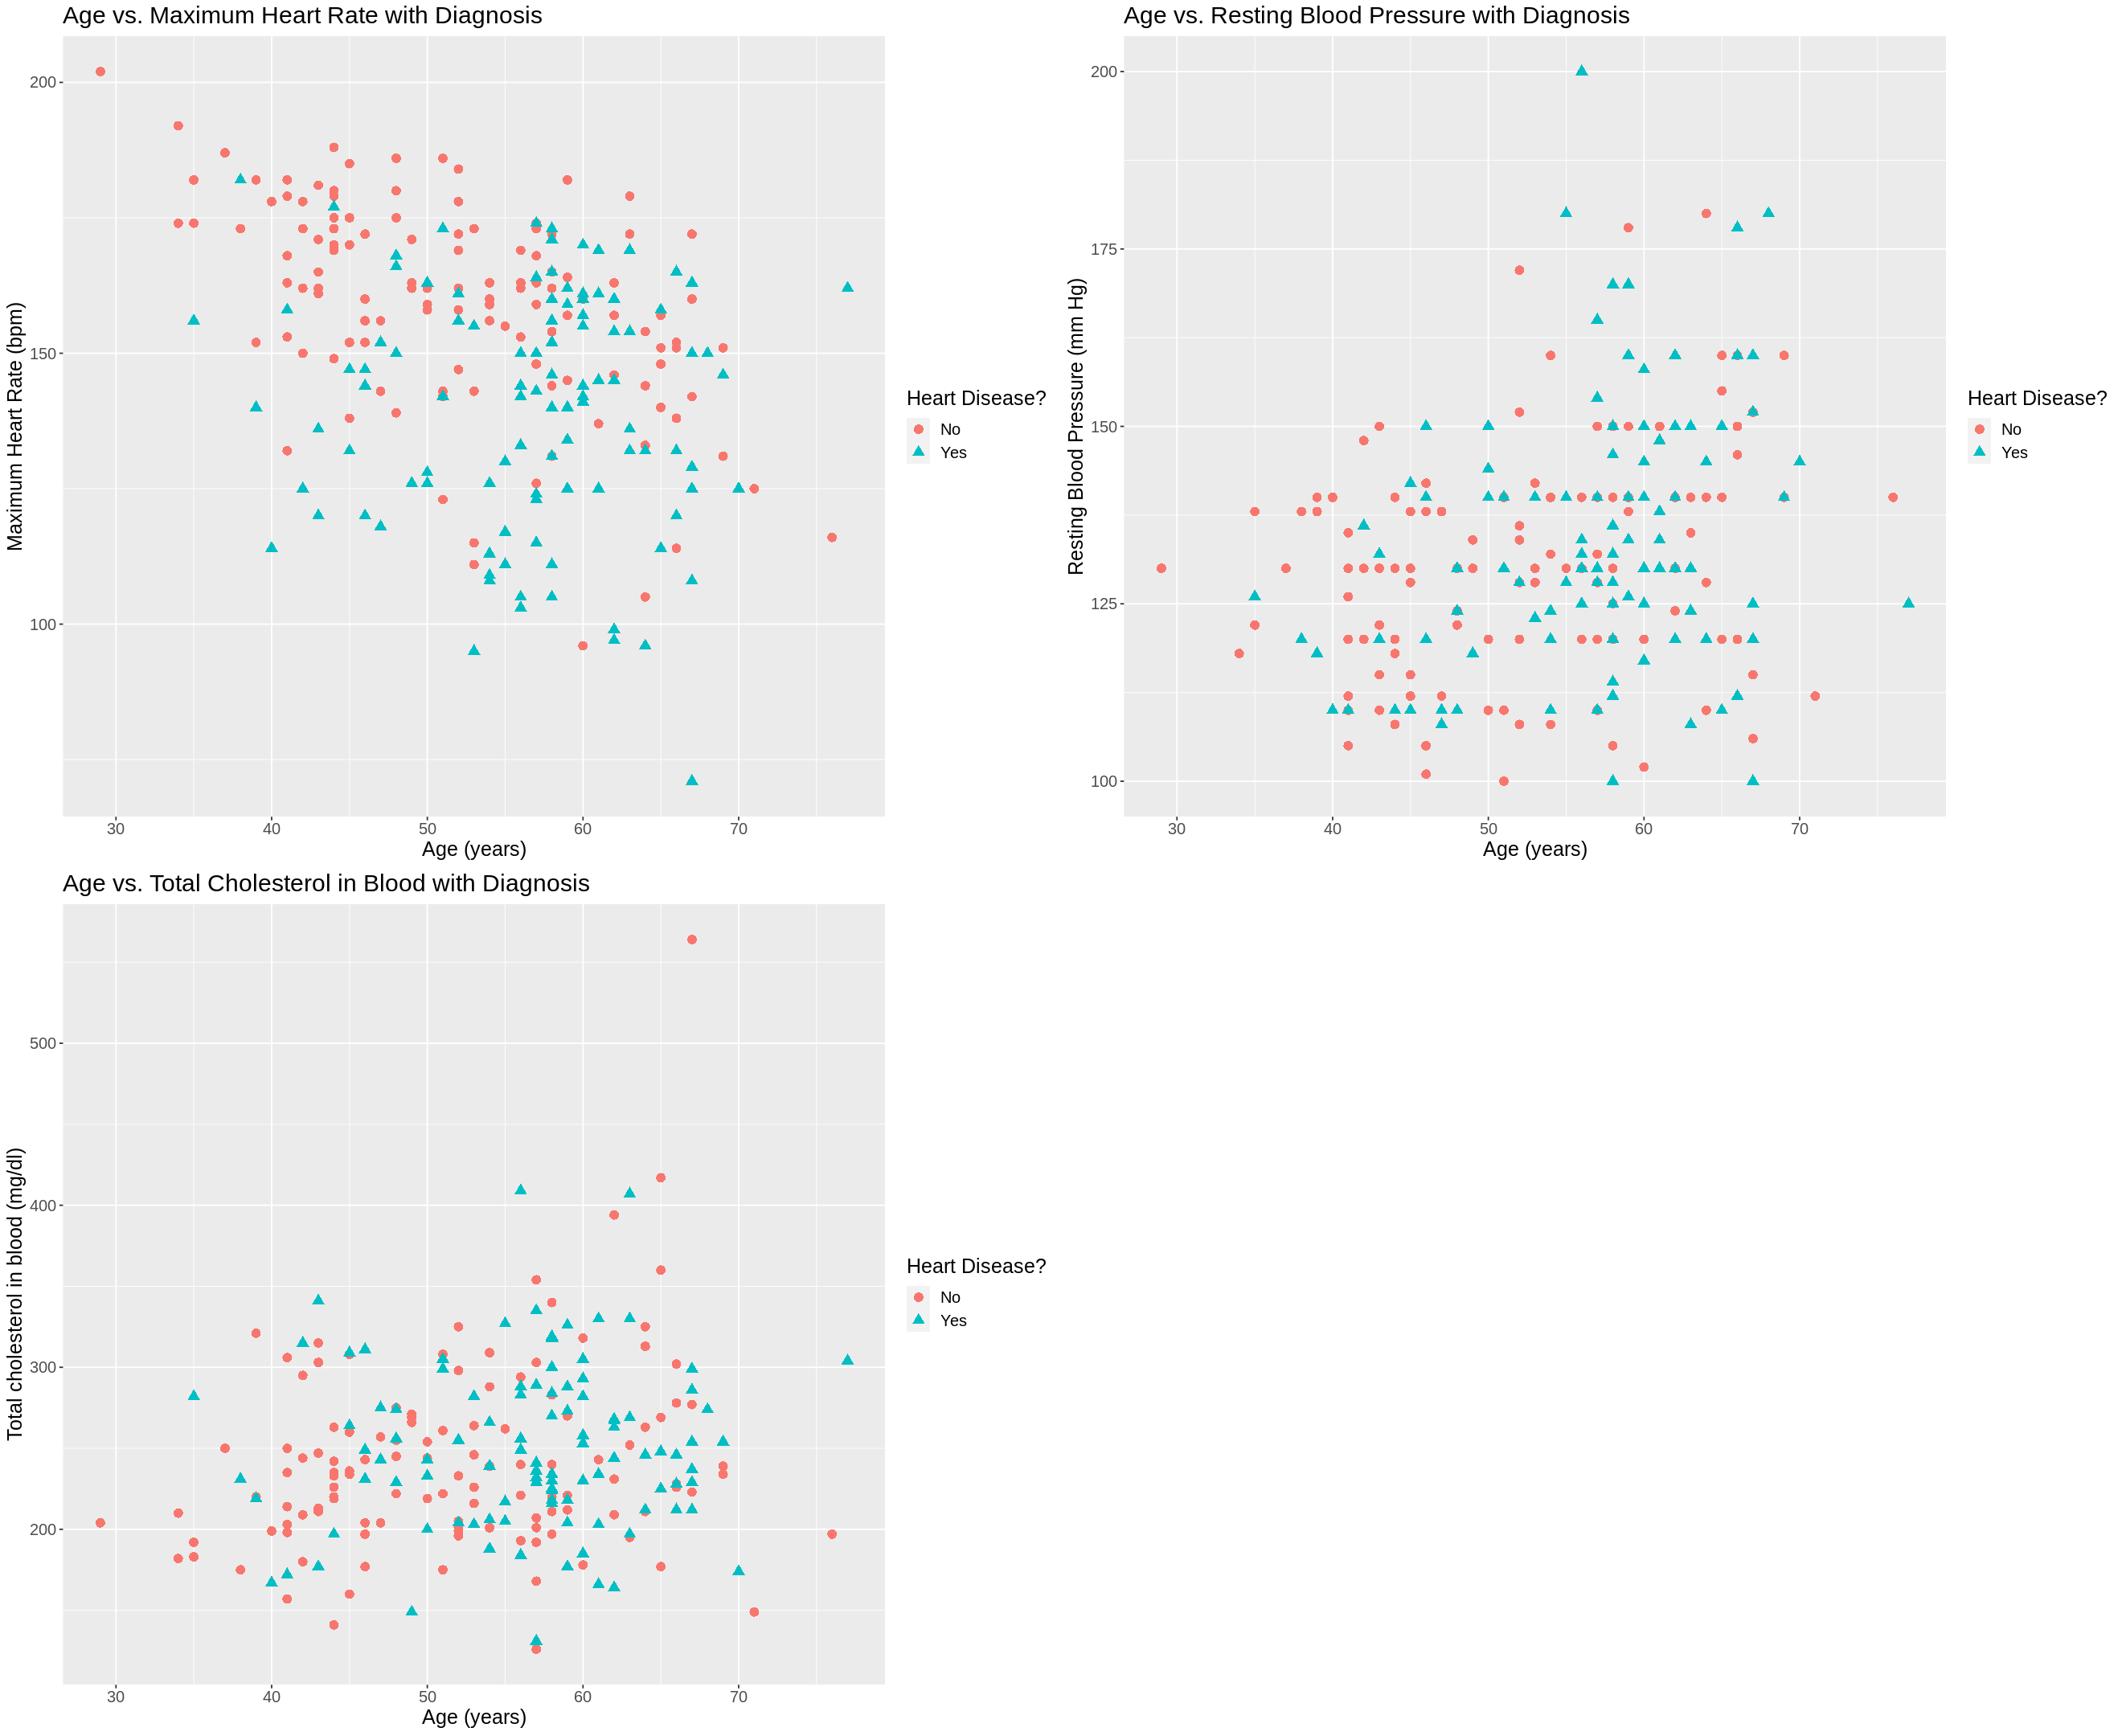

In [15]:
# creating a summary visualization
options(repr.plot.width = 22, repr.plot.height = 18)

age_vs_hr <- heart_train |>
    ggplot(aes(x = age, y = max_heart_rate, color = diagnosis, shape = diagnosis)) +
    geom_point(size = 3) + 
    labs(x = "Age (years)", 
         y = "Maximum Heart Rate (bpm)", 
         color = "Heart Disease?", 
         shape = "Heart Disease?") +
    ggtitle("Age vs. Maximum Heart Rate with Diagnosis") +
    theme(text = element_text(size = 15))

age_vs_bp <- heart_train |>
    ggplot(aes(x = age, y = blood_pressure, color = diagnosis, shape = diagnosis)) +
    geom_point(size = 3) + 
    labs(x = "Age (years)", 
         y = "Resting Blood Pressure (mm Hg)", 
         color = "Heart Disease?", 
         shape = "Heart Disease?") +
    ggtitle("Age vs. Resting Blood Pressure with Diagnosis") +
    theme(text = element_text(size = 15))

age_vs_chol <- heart_train |>
    ggplot(aes(x = age, y = chol, color = diagnosis, shape = diagnosis)) +
    geom_point(size = 3) + 
    labs(x = "Age (years)", 
         y = "Total cholesterol in blood (mg/dl)", 
         color = "Heart Disease?", 
         shape = "Heart Disease?") +
    ggtitle("Age vs. Total Cholesterol in Blood with Diagnosis") +
    theme(text = element_text(size = 15))

# plotting grids together
plot_grid(age_vs_hr, age_vs_bp, age_vs_chol,
          label_size = 10)

*Figure 1: Summary visual with age plotted against different risk factors with the diagnosis of heart disease shown via shape and colour.*

From Figure 1, we see a weak positive correlation between age and resting blood pressure and a negative correlation between age and heart rate. On the other hand, there seems to be no correlation between age and the amount of cholesterol in an individual's blood. Additionally, there seems to be more individuals diagnosed with heart disease as age increases. Therefore, our preliminary data analysis helped us formulate our predictive question and choose the variables age, blood pressure, and maximum heart rate to use as predictors for whether an individual with be diagnosed with heart disease.

## 4. Methods

As the aim of our project is to create a K-nearest neighbours classification model, we will begin our data analysis by performing a cross validation of ten folds to select an optimal K value for our model. For this step, our recipe will include the variables `age`, `blood_pressure`, and `max_heart_rate`, as we would like to explore the relationship between these predictors and an individual's diagnosis of heart disease.

Next, we will build our model and perform a K-nearest neighbour classification with the best k-value found in the previous step. We will use the model to predict observations from our testing data and compare the predictions to the true values in the test set to test the model's accuracy.

Lastly, we will use a confusion matrix to visualize how many observations were correctly predicted.

## 5. Expected Outcome and Significance

We expect age and maximum heart rate to be strong predictors of heart disease as previous research has shown that an individual’s risk of heart disease increases with age (Jousilahti et al., 1999). Additionally, increased maximum heart rate and blood pressure are also associated with an increased risk of heart disease (Tackling, 2022).

These findings may help us predict early-onset heart disease in individuals globally by taking into account their maximum heart rate and blood pressure during early check-ups to prevent further risk of heart disease.

Creating this classification model may prompt further questions into research for heart disease such as:
- How do categorical variables like sex, type of chest pain, resting electrocardiographic results and number of major vessels affect whether an individual develops heart disease?
- Which subset of variables in the data set will result in the highest accuracy of predicting heart disease?
- How can the classification model be changed to reflect the range of values for heart rate and blood pressure in children?

## References

Aha, D. W. (1988). Heart Disease Data Set [Data set]. UCI: Machine Learning Repository. https://archive.ics.uci.edu/ml/datasets/Heart+Disease.

Chambers, J. B. (2021). Epidemiology of valvular heart disease. In C. M. Otto & R. O. Bonow (Eds.), Valvular Heart Disease: A Companion to Braunwald’s Heart Disease, Fifth Edition (pp. 1-21). Elsevier, Inc.

Jousilahti, P., Vartiainen, E., Tuomilehto, J., & Puska, P. (1999). Sex, age, cardiovascular risk factors, and coronary heart disease. Circulation, 99(9), 1165–1172. https://doi.org/10.1161/01.cir.99.9.1165.

Tackling, G., Borhade M.B. Hypertensive Heart Disease. (2022). https://www.ncbi.nlm.nih.gov/books/NBK539800/.

Virani, S. S., Alonso, A., Aparicio, H. J., Benjamin, E. J., Bittencourt, M. S., Callaway, C. W., . . . Tsao, C. W. (2021). Heart disease and stroke statistics—2021 update. Circulation, 143(8). doi:10.1161/cir.0000000000000950. 